In [306]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from uncertainties import ufloat

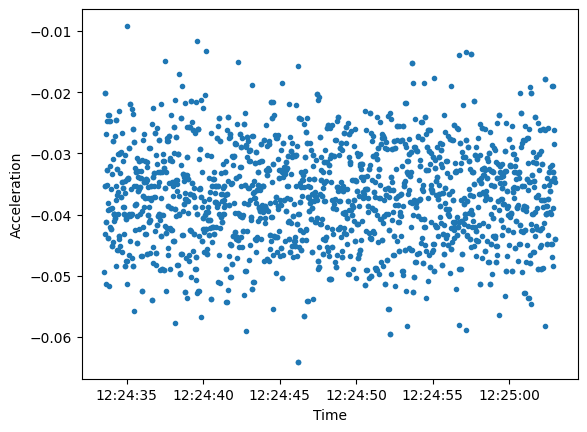

In [307]:
### Plotting raw data only for copper, axis = 0 ###
rawdata = pd.read_csv("C:\\Users\\chril\\Documents\\Python Scripts\\Fluid\\Lab6\\Copper\\copper_fl_u.csv", delimiter=",", header=None)
rawdata = rawdata[rawdata.iloc[:,2] == 0]
rawdata.iloc[:,0] = rawdata.iloc[:,0].replace("2024-11-12_","", regex=True)
rawdata.iloc[:,0] = pd.to_datetime(rawdata.iloc[:,0], format="%H:%M:%S.%f")

plt.plot(rawdata.iloc[:,0], rawdata.iloc[:,3], '.', label="Raw data")
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.savefig("C:\\Users\\chril\\Documents\\Python Scripts\\Fluid\\Lab6\\Plots\\rawdataCUa0.png")

In [308]:
def fitfunc(x, a, b):
    return a*x + b

In [309]:
def R2Score(Material):
    FullData = pd.DataFrame()
    filename = "C:\\Users\\chril\\Documents\\Python Scripts\\Fluid\\Lab6\\" + Material.capitalize() + "\\" + Material + "_fl_"
    Df = pd.DataFrame()
    for i in ["02", "03", "04", "06", "u"]:
        Data = pd.read_csv(filename + i + ".csv", delimiter = ",", header = None)
        Df[Material + i + "_time"] = Data[0] #Names the columns
        Df[Material + i + "_axis"] = Data[2]
        Df[Material + i + "_acceleration"] =Data[3]
    Df = Df.dropna() #Makes sure they have run for equal amount of time

    results = pd.DataFrame()
    for axis in range(3): #Calculates the R2 score for each axis
        AvgAcc, stdAcc, FlowRate = [], [], []
        AxisDf = Df[Df[Material + "02_axis"]  == axis] #New temporary dataframe for each axis

        for i in ["02", "03", "04", "06"]: #Calculates the average acceleration for each flowrate
            AvgAcc.append(AxisDf[Material + i + "_acceleration"].mean()) 
            stdAcc.append(AxisDf[Material + i + "_acceleration"].std()/np.sqrt(len(AxisDf[Material + i + "_acceleration"])))
            FlowRate.append(int(i))

        par, cov = curve_fit(fitfunc, FlowRate, AvgAcc, sigma = stdAcc, absolute_sigma=True) #Fits the data to a linear function

        unkownAcc = AxisDf[Material + "u_acceleration"].mean() #Calculates the unknown flowrate
        
        dict = {
            "Material": [Material], 
            "Axis": [axis],  
            "R2_score": [r2_score(AvgAcc, fitfunc(np.asarray(FlowRate), *par))], 
            "Unknown flowrate": [(unkownAcc - par[1])/par[0] ],
            "Flowrate errror": [np.sqrt((1/par[0])**2* (np.std(AxisDf[Material + "u_acceleration"])/len(AxisDf[Material + "u_acceleration"]))**2
                                        + (1/par[0])**2*cov[1,1] 
                                        + ((unkownAcc - par[1])/(par[0]**2))**2*cov[0,0])],
            } #Creates a dictionary with the results
        results = pd.DataFrame(dict) #Creates a dataframe with the results
        #write to csv
        results.to_csv("C:\\Users\\chril\\Documents\\Python Scripts\\Fluid\\Lab6\\Results\\" + Material + str(axis)+ "_R2_score.csv", header = True)
        
        if axis == 0: #Plots the data for all materials, only for axis = 0
            a = ufloat(par[0], np.sqrt(cov[0,0])) #Calculates the parameters and uncertainties
            b = ufloat(par[1], np.sqrt(cov[1,1]))
            plt.errorbar(FlowRate, AvgAcc, yerr = stdAcc, fmt = "o", label = "Data")
            plt.plot(
                FlowRate, 
                fitfunc(np.asarray(FlowRate), *par), 
                label = f"Fit, $a = {a:L}, b = {b:L}$"
                )
            plt.xlabel("Flowrate")
            plt.ylabel("Acceleration")
            plt.legend()
            plt.savefig("C:\\Users\\chril\\Documents\\Python Scripts\\Fluid\\Lab6\\Plots\\" + Material + "_axis" + str(axis) + ".png")
            plt.show()


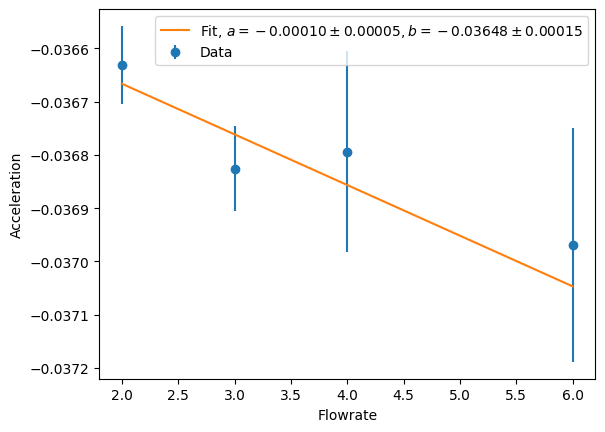

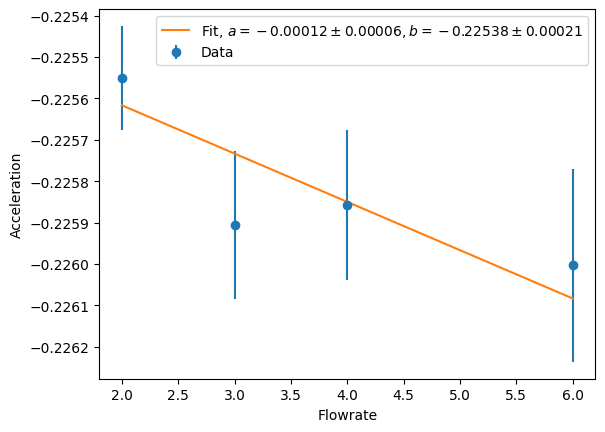

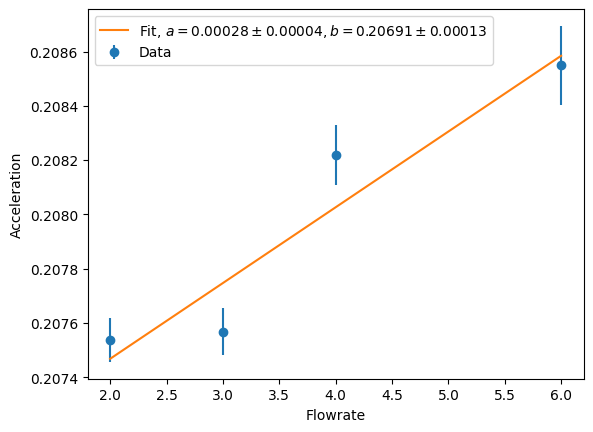

In [310]:
for mat in ["copper", "galvanized", "pvc"]:
    R2Score(mat)

In [311]:
Fulldata = pd.DataFrame()
for mat in ["copper", "galvanized", "pvc"]:
    for axis in range(3):
        data = pd.read_csv("C:\\Users\\chril\\Documents\\Python Scripts\\Fluid\\Lab6\\Results\\" + mat + str(axis) + "_R2_score.csv", delimiter = ",", header = 0)
        print(data["Material"].values[0], 
              round(data["Axis"].values[0], 2), 
              round(data["R2_score"].values[0], 2), 
                "${:L}$".format(ufloat(data["Unknown flowrate"].values[0], data["Flowrate errror"].values[0])).replace(" ", "")
        )
# data.to_csv("C:\\Users\\chril\\Documents\\Python Scripts\\Fluid\\Lab6\\Results\\FullData.csv", header = True)

copper 0 0.73 $5.3\pm3.3$
copper 1 0.38 $6.0\pm1.8$
copper 2 0.5 $0\pm8$
galvanized 0 0.64 $4.3\pm2.9$
galvanized 1 0.27 $3\pm4$
galvanized 2 0.39 $10\pm9$
pvc 0 0.9 $6.2\pm1.0$
pvc 1 0.07 $-7\pm11$
pvc 2 -0.37 $1\pm5$
